In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")
from scipy import stats

In [2]:
import sys
sys.path.insert(0, "/home1/smaruj/akitaX1-analyses/utils/")
from reading_averaging_utils import read_multi_model_single_mutagenesis_data

In [3]:
# directory with data
data_dir = "/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_single_mutagenesis"

In [4]:
df = read_multi_model_single_mutagenesis_data(data_dir)

In [5]:
# Initialize an empty list to store wild_type_average values for each site
wild_type_averages = []

# for storing non-wt average SCD values for each position
non_wild_type_scd_values = np.zeros(49)

In [6]:
# min and max for plotting matrices for each site
min = -40
max = 20

In [7]:
colormap = "plasma"

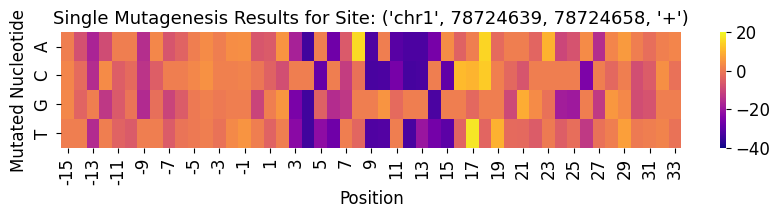

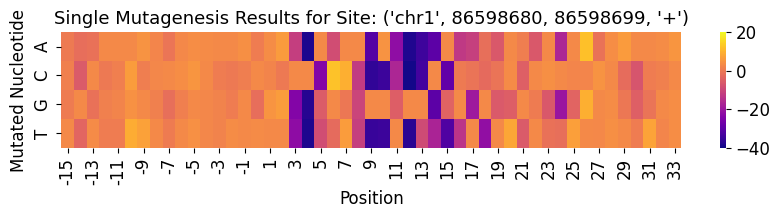

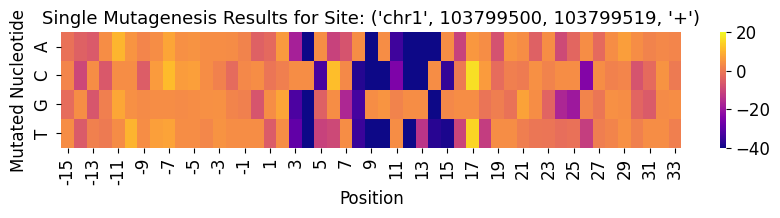

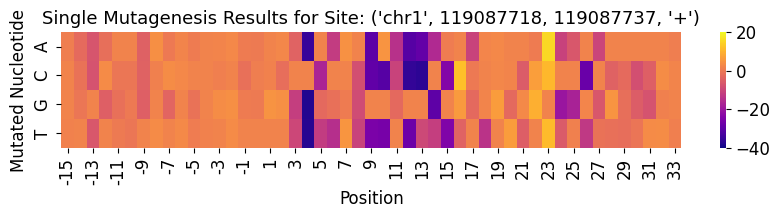

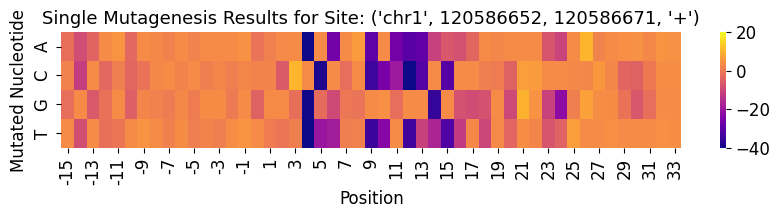

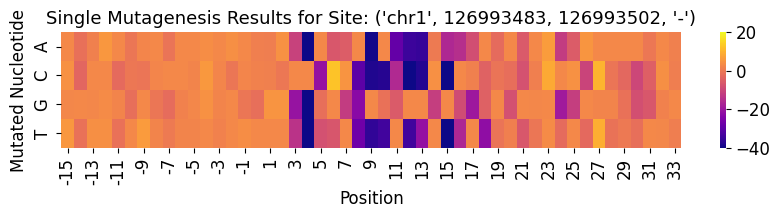

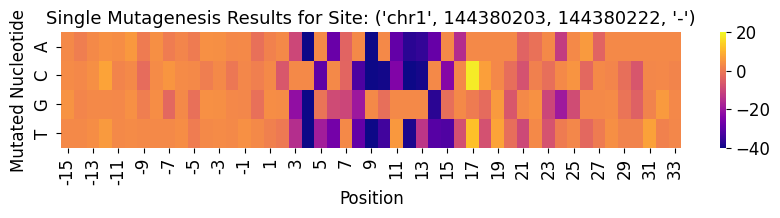

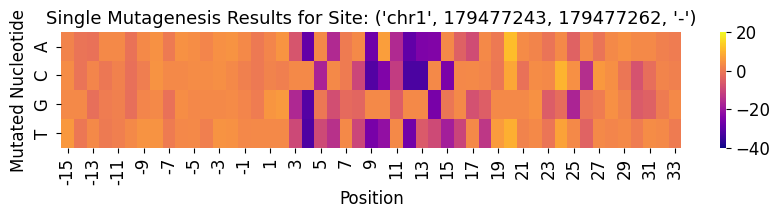

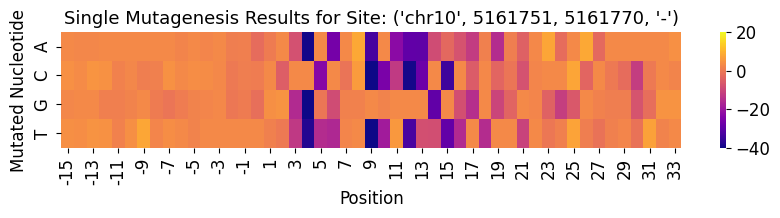

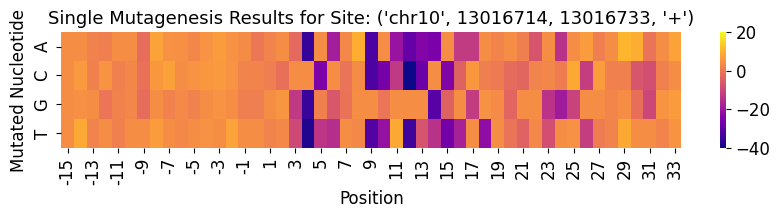

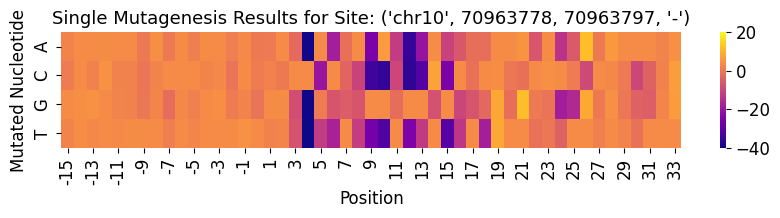

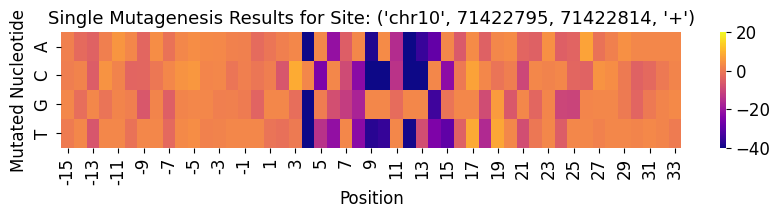

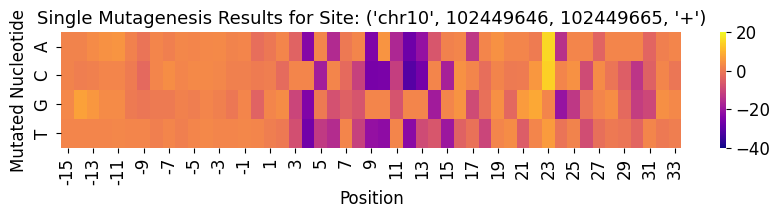

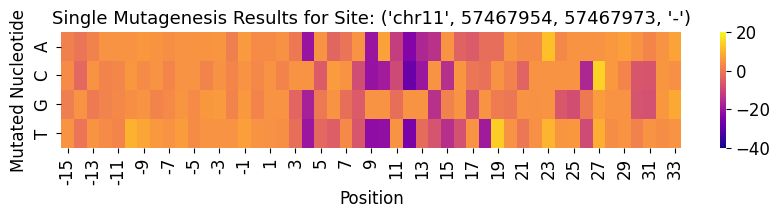

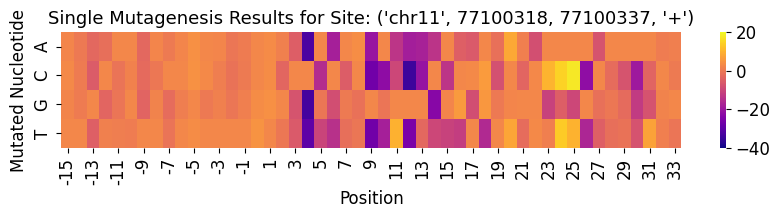

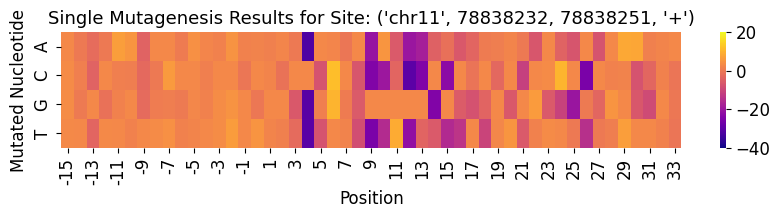

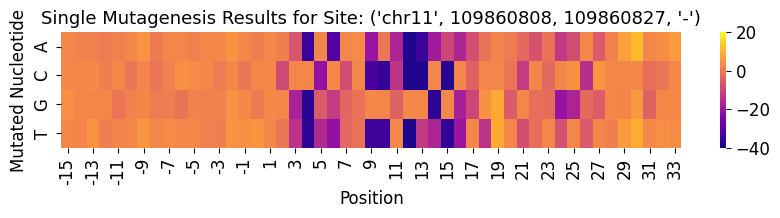

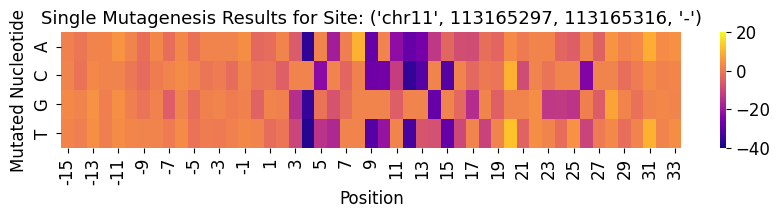

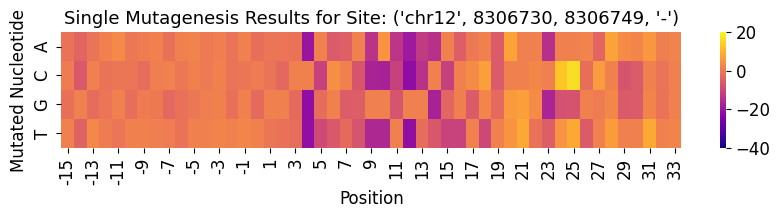

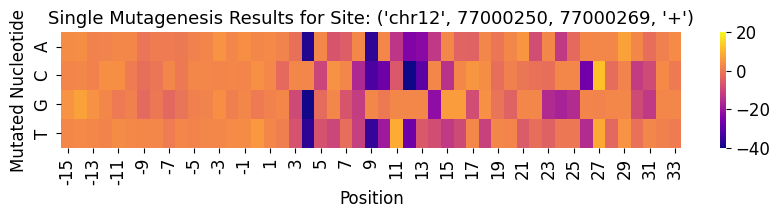

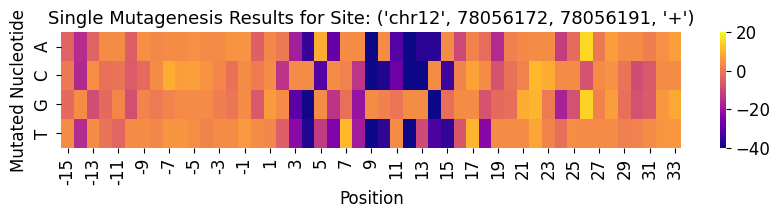

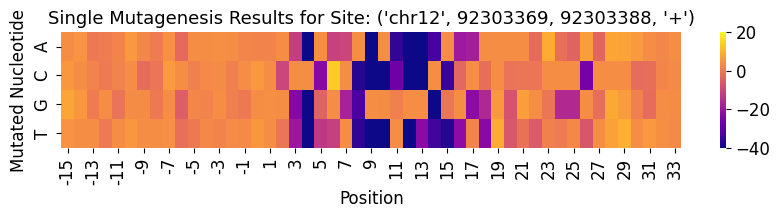

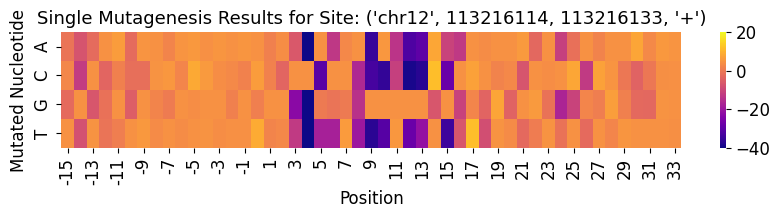

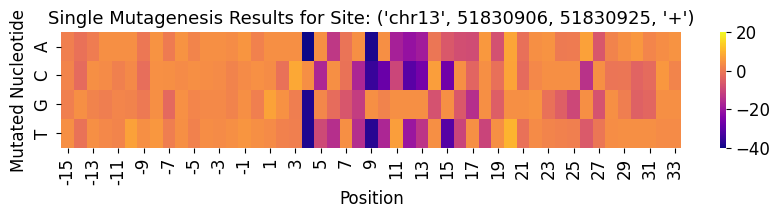

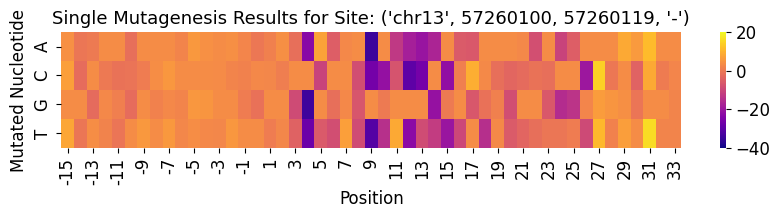

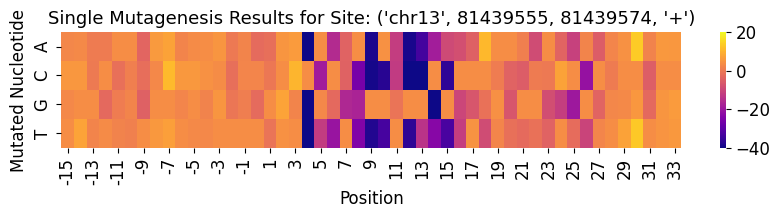

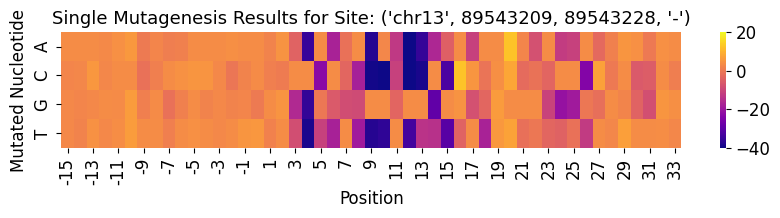

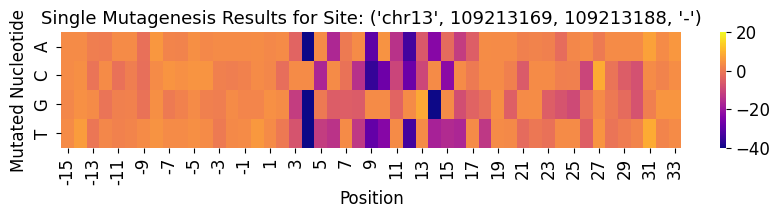

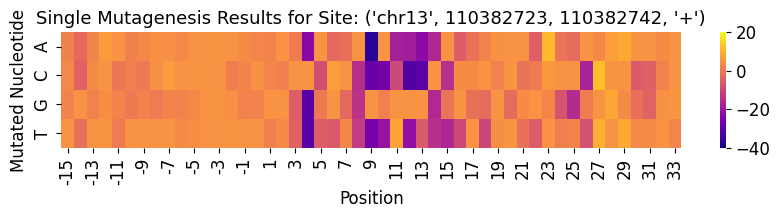

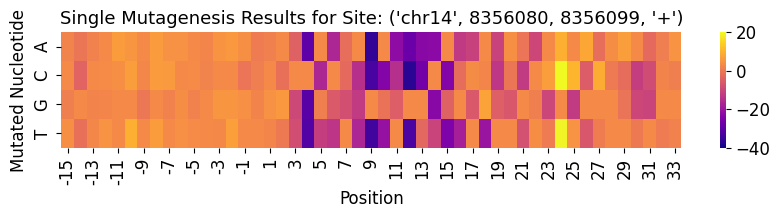

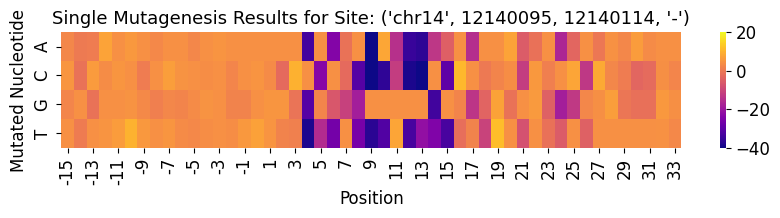

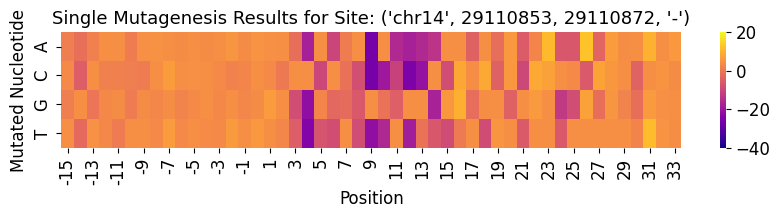

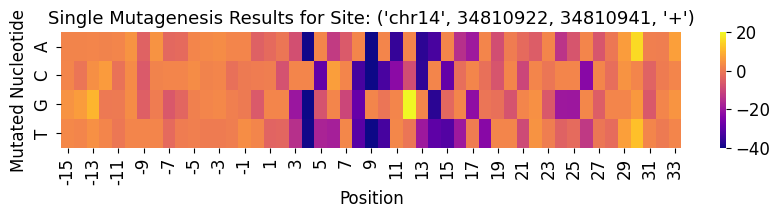

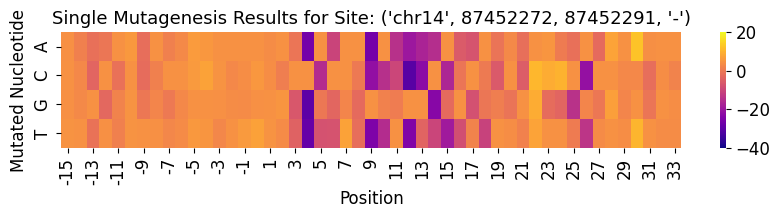

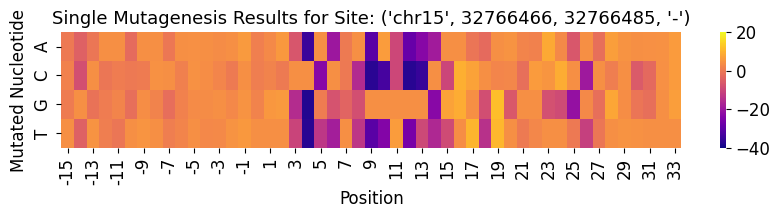

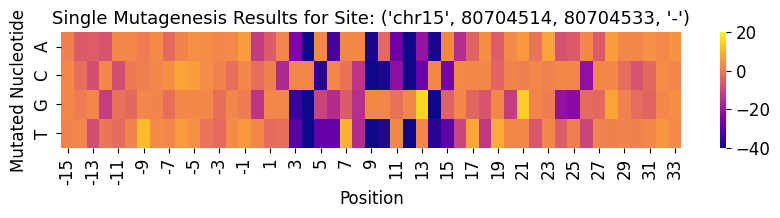

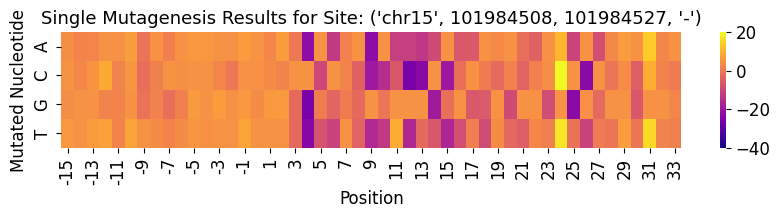

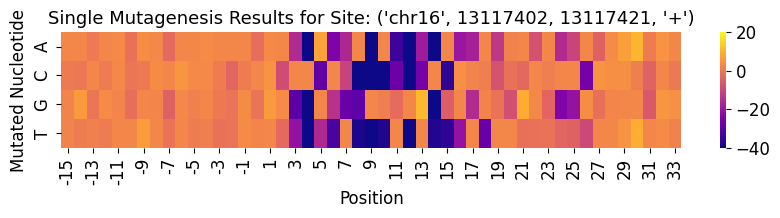

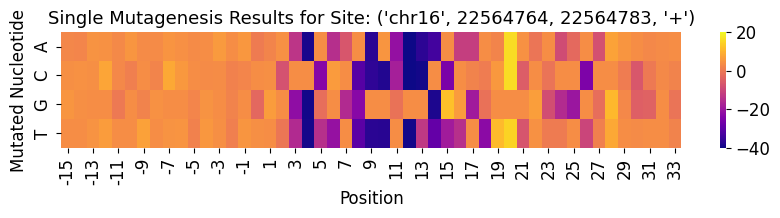

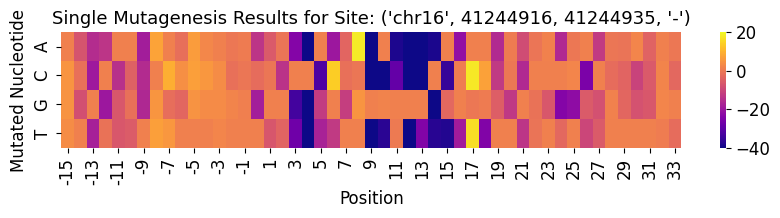

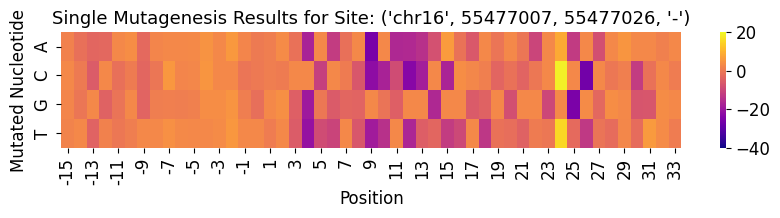

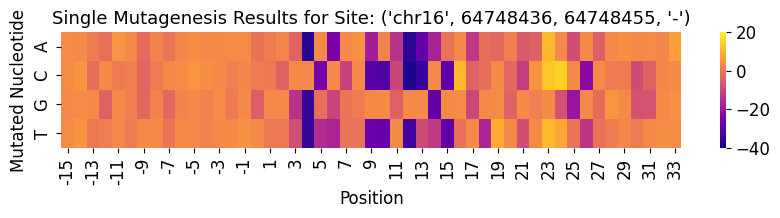

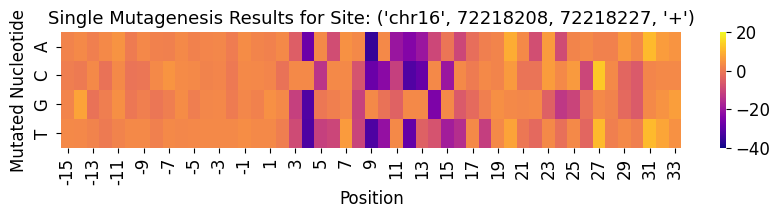

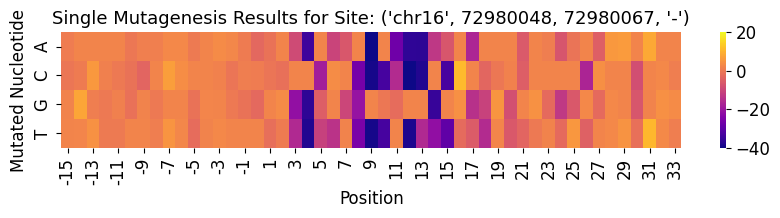

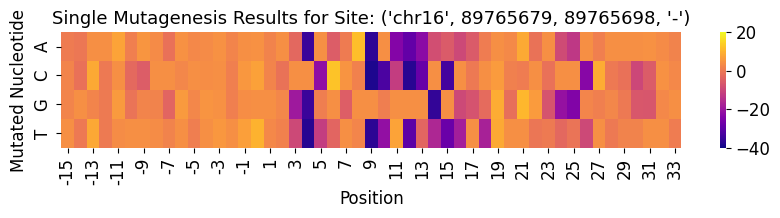

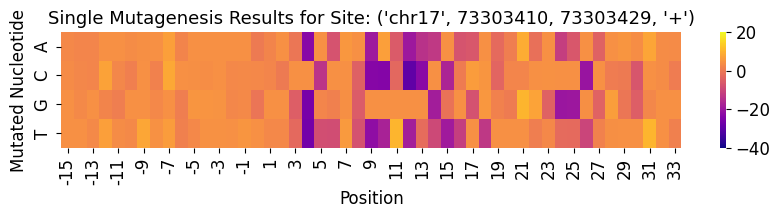

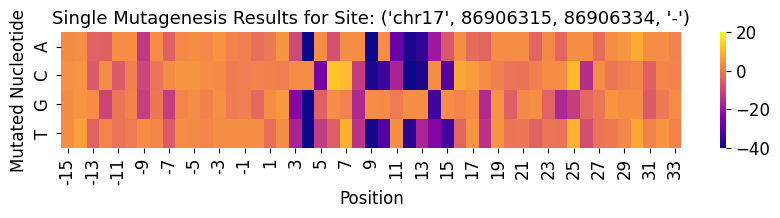

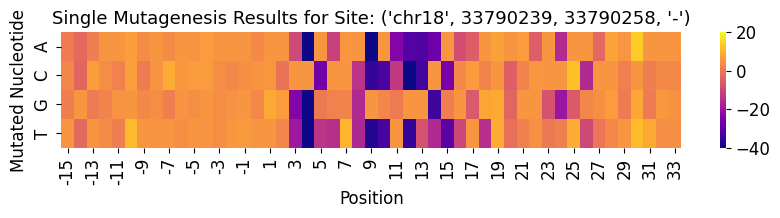

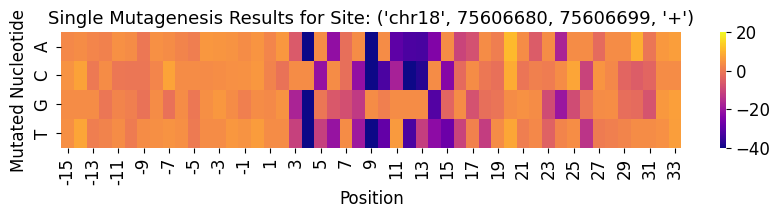

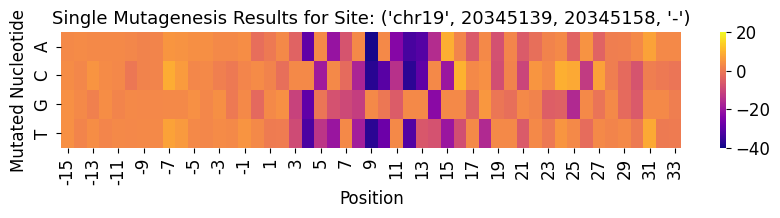

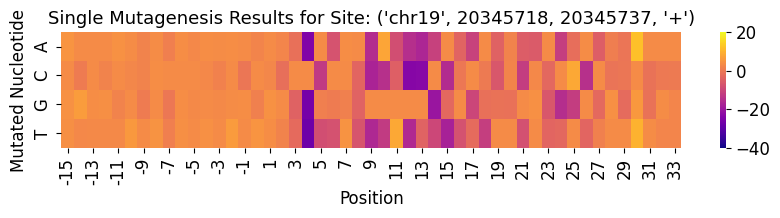

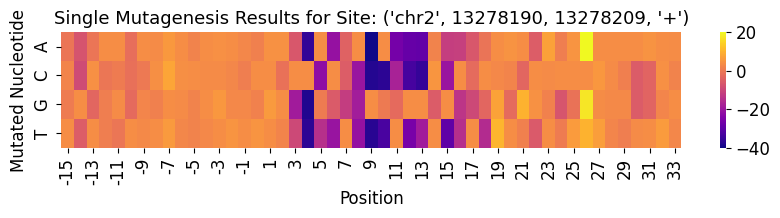

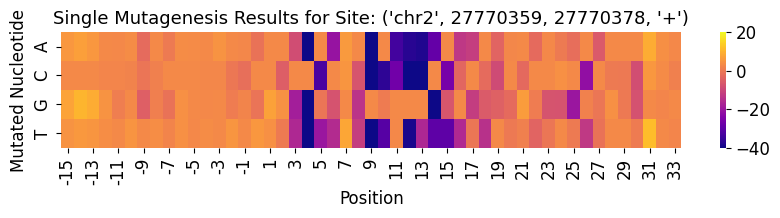

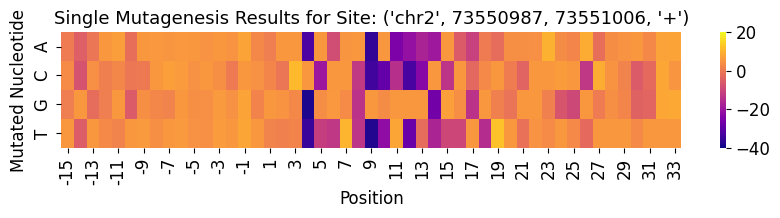

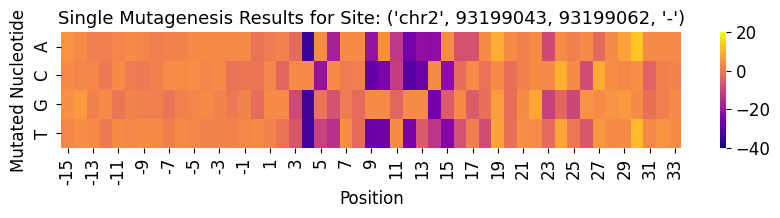

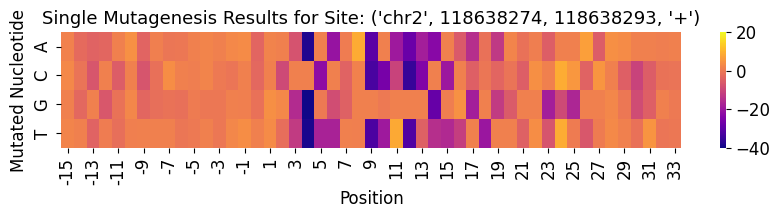

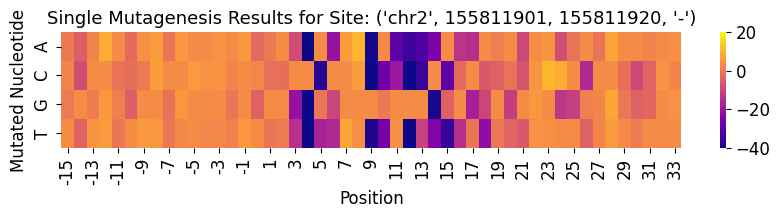

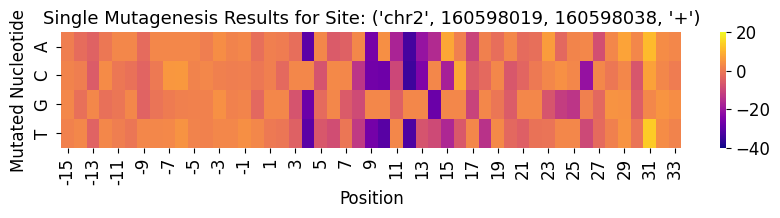

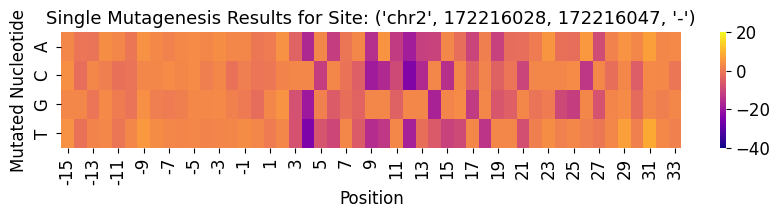

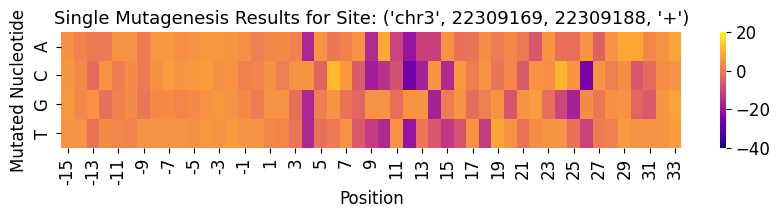

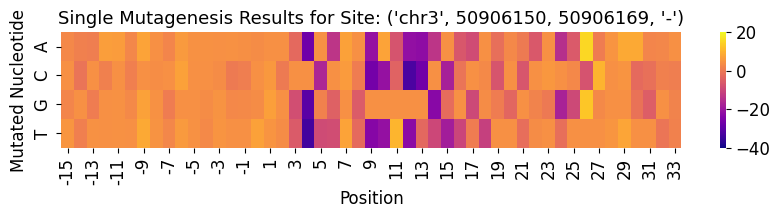

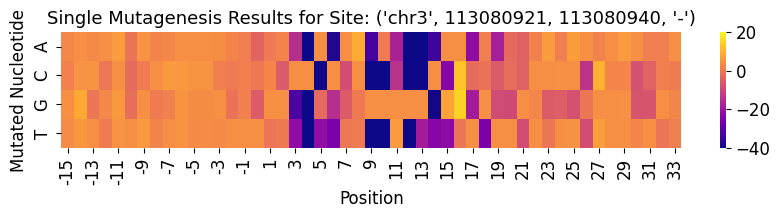

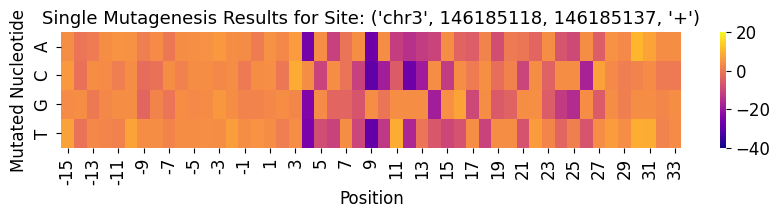

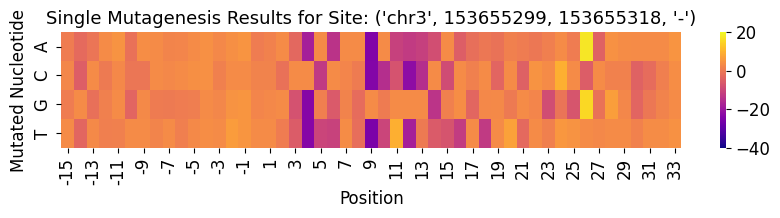

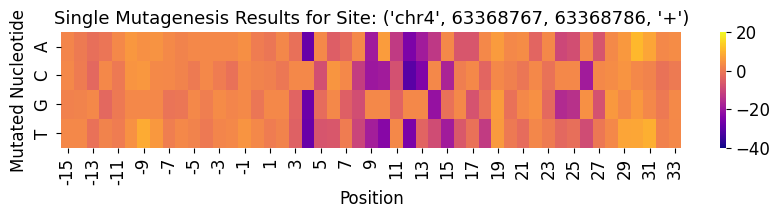

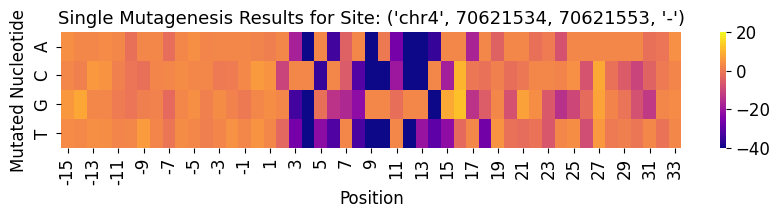

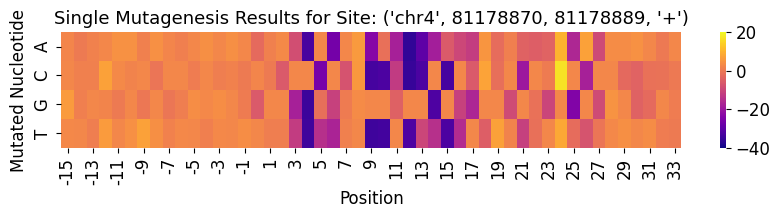

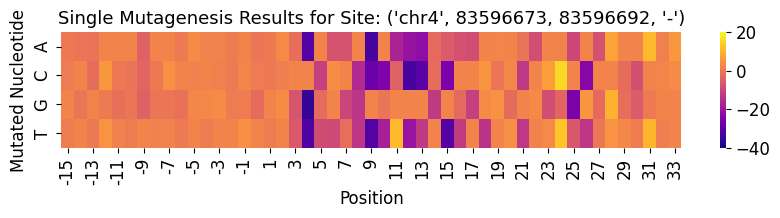

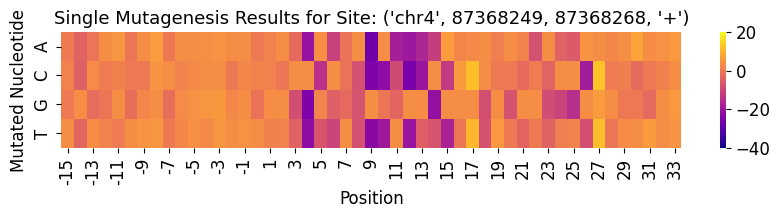

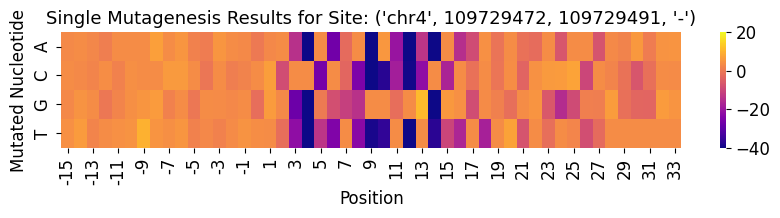

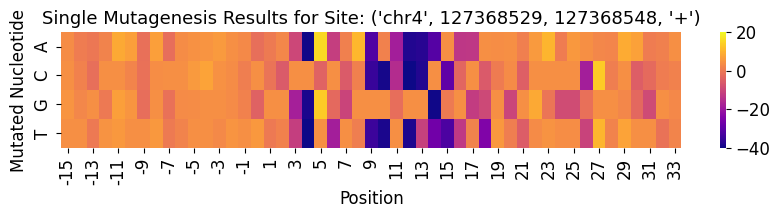

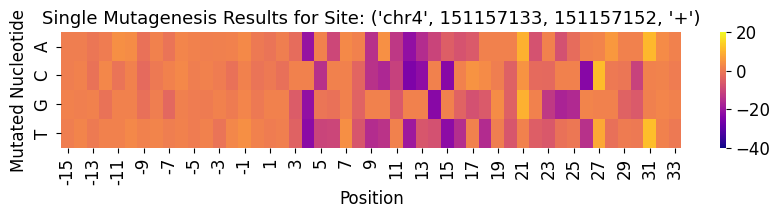

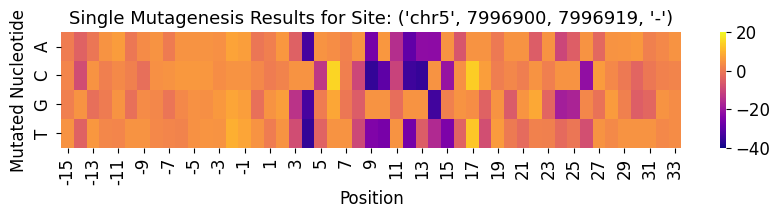

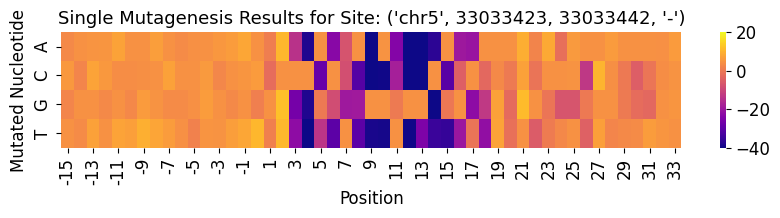

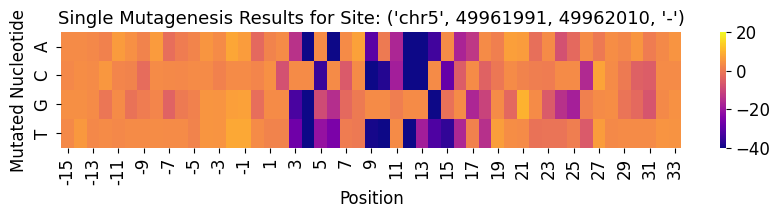

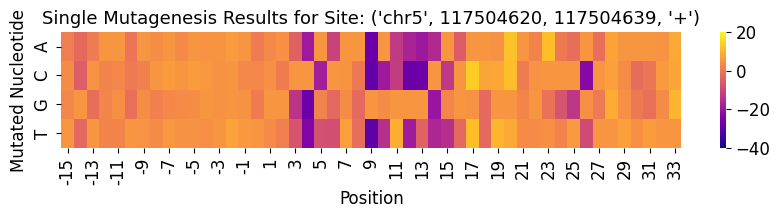

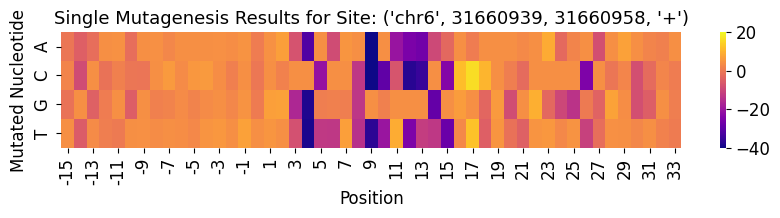

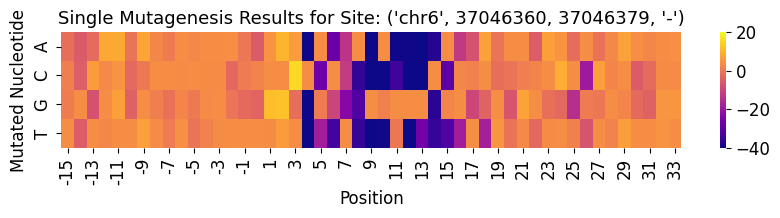

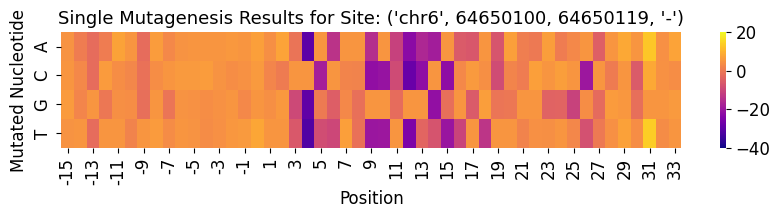

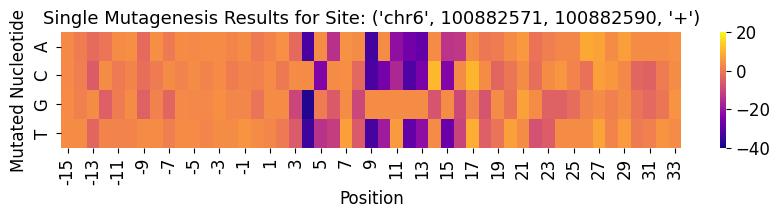

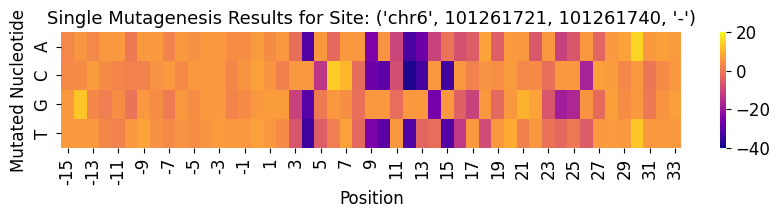

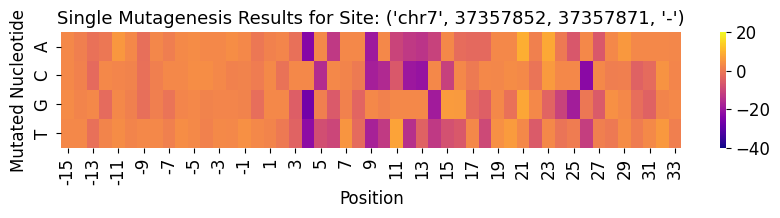

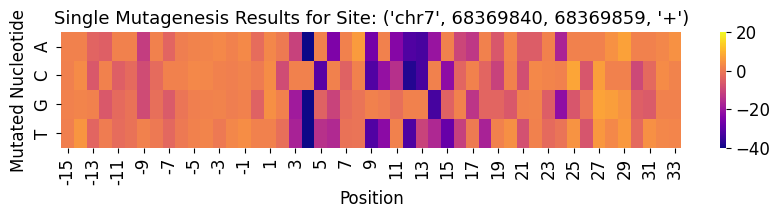

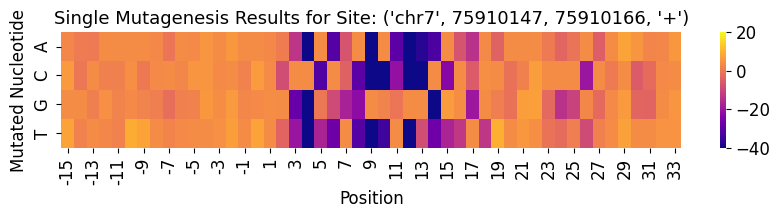

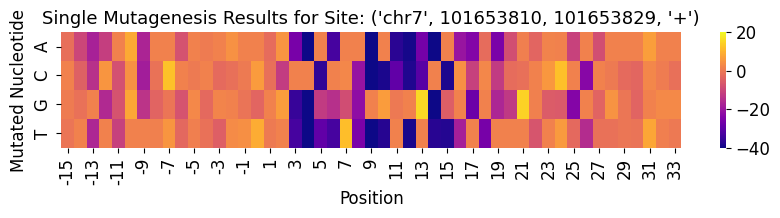

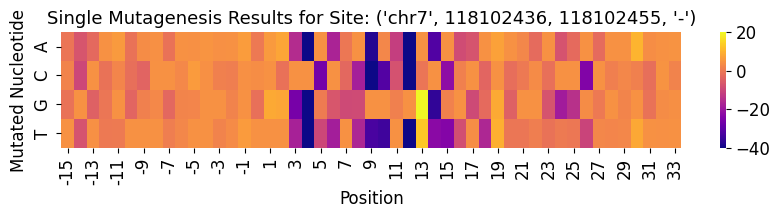

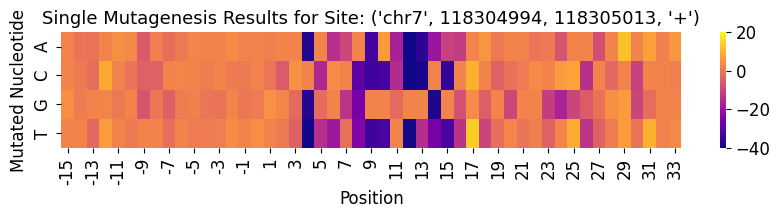

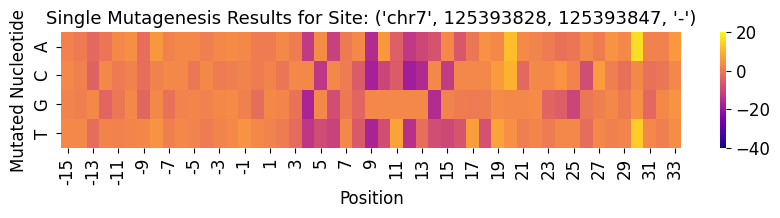

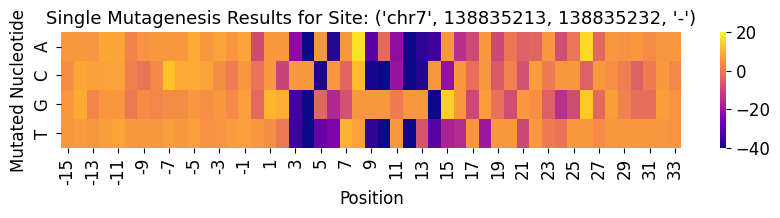

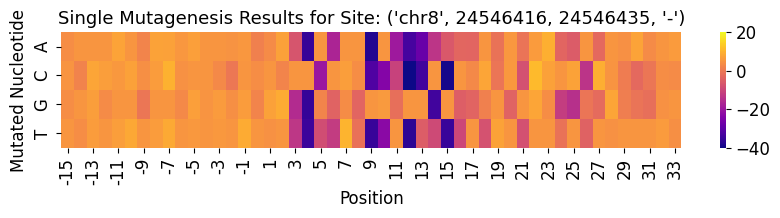

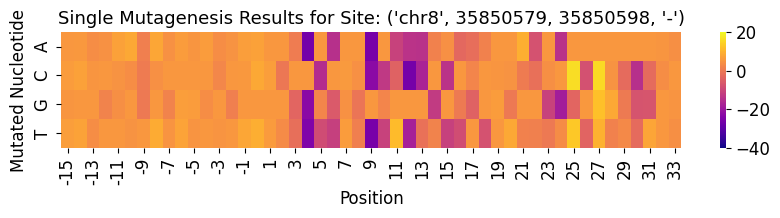

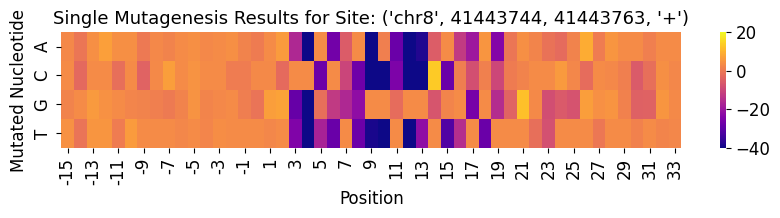

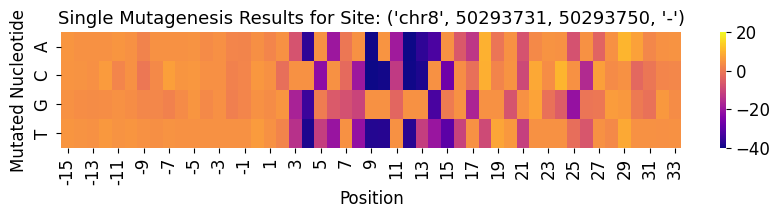

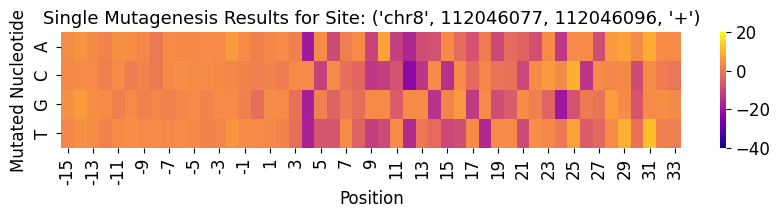

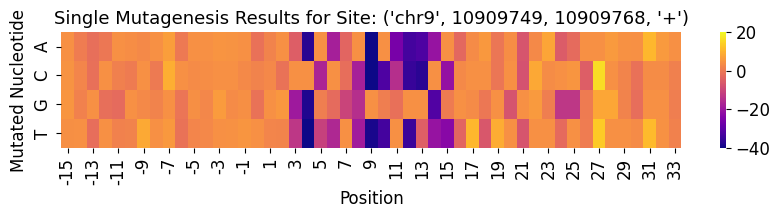

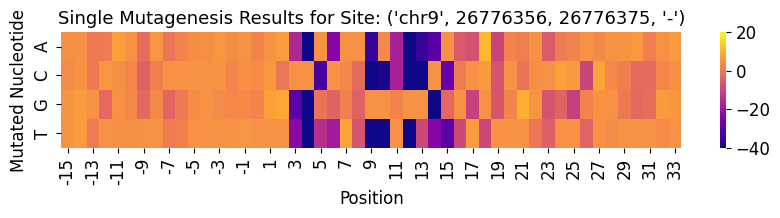

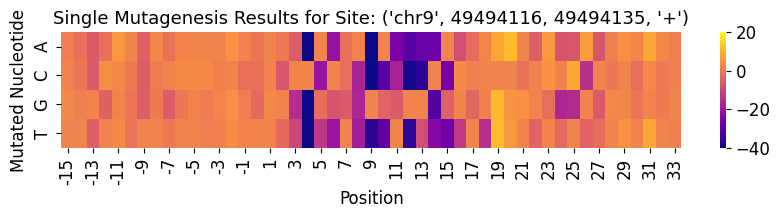

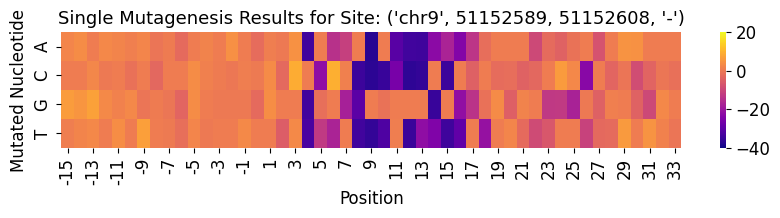

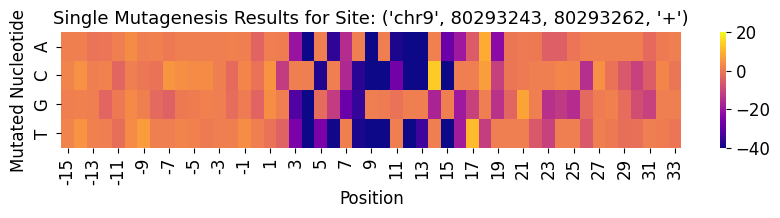

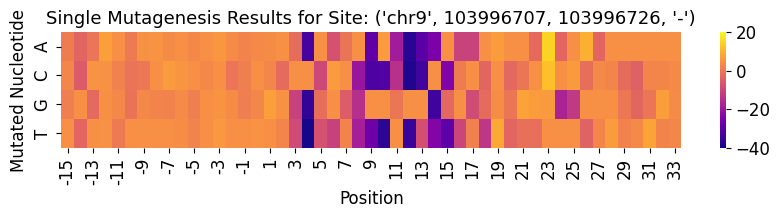

In [8]:
# Iterate over each site separately
for site, site_df in df.groupby(['chrom', 'start', 'end', 'strand']):
    # Initialize an empty DataFrame to store reshaped data
    reshaped_data = []

    # Calculate average SCD value for wild type (original_nucleotide)
    wild_type_average = site_df.loc[site_df['mutated_nucleotide'] == site_df['original_nucleotide'], 'SCD'].mean()

    # Append wild_type_average value to the list
    wild_type_averages.append(wild_type_average)
    
    # Iterate over each position
    for position, position_df in site_df.groupby('position'):
        
        position_df['difference'] = position_df['SCD'] - wild_type_average

        non_wild_type_scd_values[position + 15] += position_df[position_df['mutated_nucleotide'] != position_df['original_nucleotide']]['SCD'].mean() - wild_type_average
        
        # Create a dictionary to store SCD values for each nucleotide
        position_data = {'position': position}
        for nucleotide, nucleotide_df in position_df.groupby('mutated_nucleotide'):
            position_data[nucleotide] = nucleotide_df['difference'].iloc[0]  # Take the first value assuming only one entry per position and nucleotide
        reshaped_data.append(position_data)
    
    # Convert the list of dictionaries to a DataFrame
    reshaped_df = pd.DataFrame(reshaped_data)

    # Plot heatmap
    plt.figure(figsize=(10, 1.5))
    sns.heatmap(reshaped_df.set_index('position').T, cmap=colormap, annot=False, vmin=min, vmax=max)
    plt.title(f'Single Mutagenesis Results for Site: {site}')
    plt.xlabel('Position')
    plt.ylabel('Mutated Nucleotide')
    plt.show()

# Calculate the average SCD values for non-wild-type substitutions across all sites
mean_non_wild_type_scd = non_wild_type_scd_values / len(df.groupby(['chrom', 'start', 'end', 'strand']))

## Averaged over all 100 sites

In [9]:
all_wild_type_average = np.array(wild_type_averages).mean()

In [10]:
# max and min unified with pairwise mutagenesis
unified_min = -50
unified_max = 3

In [11]:
# Convert the 'SCD' column to float64
df['SCD'] = df['SCD'].astype(np.float32)

# First, create a DataFrame with all possible combinations of position and nucleotide
positions = range(-15, 34)
nucleotides = ['A', 'C', 'G', 'T']
index = pd.MultiIndex.from_product([nucleotides, positions], names=['nucleotide', 'position'])
average_df = pd.DataFrame(index=index, columns=['average_SCD'])

# Then, calculate the average SCD for each combination
for nucleotide in nucleotides:
    for position in positions:
        # Filter rows based on nucleotide and position
        subset = df[(df['mutated_nucleotide'] == nucleotide) & (df['position'] == position)]
        # Calculate average SCD
        average_SCD = subset['SCD'].mean()
        # Fill the corresponding cell in the new DataFrame
        average_df.loc[(nucleotide, position), 'average_SCD'] = average_SCD

# Reshape the DataFrame to have nucleotides as rows and positions as columns
average_matrix = average_df.reset_index().pivot(index='nucleotide', columns='position', values='average_SCD')

average_matrix = average_matrix.astype(np.float32) - all_wild_type_average

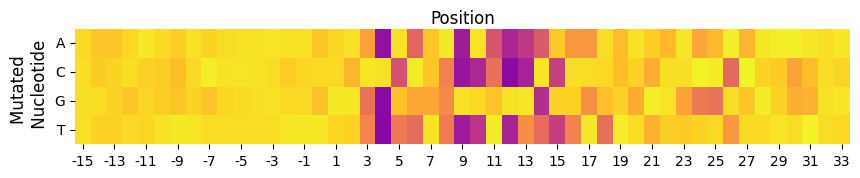

In [20]:
plt.figure(figsize=(10, 1.5))
ax = sns.heatmap(average_matrix, cmap=colormap, annot=False, vmin=unified_min, vmax=unified_max, cbar=False)

# Moving 'Position' label to the top
ax.xaxis.set_label_position('top') 
plt.xlabel('Position', fontsize=12)

plt.ylabel('Mutated \n Nucleotide', fontsize=12)

# Adjusting tick label rotation
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjusting colorbar label size
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=10)

# plt.savefig("single_mutagenesis.pdf", format="pdf", bbox_inches="tight")
plt.show()

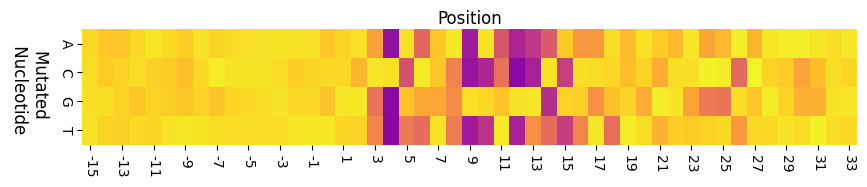

In [21]:
# Calculate the mean SCD value for each position and each nucleotide across all sites
mean_scd = df.groupby(['position', 'mutated_nucleotide'])['SCD'].mean().unstack().T - all_wild_type_average

plt.figure(figsize=(10, 1.5))
ax = sns.heatmap(average_matrix, cmap=colormap, annot=False, vmin=unified_min, vmax=unified_max, cbar=False)

# Moving 'Position' label to the top
ax.xaxis.set_label_position('top') 
plt.xlabel('Position', fontsize=12)

plt.ylabel('Mutated \n Nucleotide', fontsize=12, rotation=270, labelpad = 35)

# Adjusting tick label rotation
plt.xticks(rotation=270, fontsize=10)
plt.yticks(rotation=270, fontsize=10)

# Adjusting colorbar label size
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=10, rotation=270)

# plt.savefig("horizontal_single_mutagenesis.pdf", format="pdf", bbox_inches="tight")
plt.show()

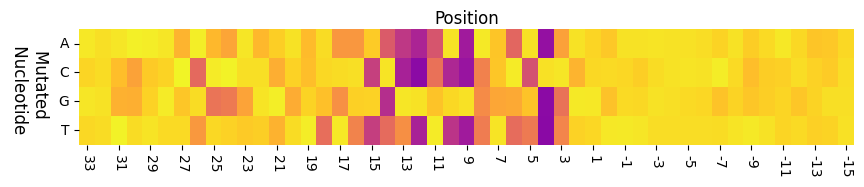

In [31]:
flipped_mean_scd = mean_scd.iloc[:, ::-1]

plt.figure(figsize=(10, 1.5))
ax = sns.heatmap(flipped_mean_scd, cmap=colormap, annot=False, vmin=unified_min, vmax=unified_max, cbar=False)

# Moving 'Position' label to the top
ax.xaxis.set_label_position('top') 
plt.xlabel('Position', fontsize=12)

plt.ylabel('Mutated \n Nucleotide', fontsize=12, rotation=270, labelpad=35)

# Adjusting tick label rotation
plt.xticks(rotation=270, fontsize=10)
plt.yticks(rotation=0, fontsize=10)  # Set rotation to 0 for readability

# Adjusting y-axis labels to reflect the flipped positions
ax.set_yticklabels(flipped_mean_scd.index)

# Adjusting colorbar label size
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=10, rotation=270)

plt.savefig("horizontal_single_mutagenesis.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# averaged wt SCD for each site
# wild_type_averages 

In [ ]:
# average difference between non-wt substitutions and wt for each position (average over all non-wt nucleotides and all sites)
# non_wild_type_scd_values

In [32]:
# np.savez("single_mutation_SCD", wild_type_averages=wild_type_averages, mean_non_wild_type_scd=mean_non_wild_type_scd)